WHAT IS TORCH.NN REALLY?
by Jeremy Howard, fast.ai.
https://pytorch.org/tutorials/beginner/nn_tutorial.html

# Get the data

In [1]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [2]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

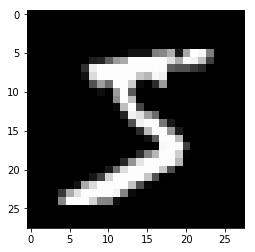

In [7]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray") #run it 2 times to view the image

In [8]:
print(x_train.shape)

(50000, 784)


In [9]:
import torch
print(torch.__version__)

1.0.0


In [10]:
x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


# Neural net from scratch (no torch.nn)

PyTorch provides methods to create random or zero-filled tensors, which we will use to create our weights and bias for a simple linear model. These are just regular tensors, with one very special addition: we tell PyTorch that they require a gradient. This causes PyTorch to record all of the operations done on the tensor, so that it can calculate the gradient during back-propagation automatically!

We are initializing the weights here with Xavier initialisation (by multiplying with 1/sqrt(n)).
Xavier = We need to pick the weights from a Gaussian distribution with zero mean and a variance of 1/N, where N specifies the number of input neurons.

In [11]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

log_softmax applies logarithm after softmax.

softmax:
exp(x_i) / exp(x).sum()

log_softmax:
log( exp(x_i) / exp(x).sum() ) = x_i - log (exp(x).sum()) = x_i - exp(x).sum().log()

In [12]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

In the above, the @ stands for the dot product operation. We will call our function on one batch of data (in this case, 64 images). This is one forward pass. Note that our predictions won’t be any better than random at this stage, since we start with random weights.

In [13]:
bs = 64  # batch size

xb = x_train[0:bs]  # a mini-batch from x
preds = model(xb)  # predictions
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([-2.4622, -2.7284, -1.6255, -2.4285, -2.3126, -2.5560, -2.6264, -2.6983,
        -2.2002, -1.9849], grad_fn=<SelectBackward>) torch.Size([64, 10])


As you see, the preds tensor contains not only the tensor values, but also a gradient function. We’ll use this later to do backprop.

Let’s implement negative log-likelihood to use as the loss function (again, we can just use standard Python)

L(y)= −log(y)
Since we use logsoftmax then preds are already on log so:
L(y) = -y
We take the mean probability of all correct classes (we know the correct classes since we are in train mode)
input is a tensor (bs, 10) so input[range(target.shape[0]), target] is the probability of all correct classes

In [40]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

In [15]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.3442, grad_fn=<NegBackward>)


In [16]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()
print(accuracy(preds, yb))

tensor(0.1406)


We can now run a training loop. For each iteration, we will:

select a mini-batch of data (of size bs)
use the model to make predictions
calculate the loss
loss.backward() updates the gradients of the model, in this case, weights and bias.
We now use these gradients to update the weights and bias. We do this within the torch.no_grad() context manager, because we do not want these actions to be recorded for our next calculation of the gradient. You can read more about how PyTorch’s Autograd records operations here.

We then set the gradients to zero, so that we are ready for the next loop. Otherwise, our gradients would record a running tally of all the operations that had happened (i.e. loss.backward() adds the gradients to whatever is already stored, rather than replacing them).

In [17]:
from IPython.core.debugger import set_trace

lr = 0.5  # learning rate
epochs = 2  # how many epochs to train for

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        #set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

In [18]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0817, grad_fn=<NegBackward>) tensor(1.)


# Use cross-entropy

If you’re using negative log likelihood loss and log softmax activation, then Pytorch provides a single function F.cross_entropy that combines the two. So we can even remove the activation function from our model.
Note that we no longer call log_softmax in the model function.

In [48]:
import torch.nn.functional as F
loss_func = F.cross_entropy

# Refactor using nn.Module

Next up, we’ll use nn.Module and nn.Parameter, for a clearer and more concise training loop. We subclass nn.Module (which itself is a class and able to keep track of state). In this case, we want to create a class that holds our weights, bias, and method for the forward step. nn.Module has a number of attributes and methods (such as .parameters() and .zero_grad()) which we will be using.

In [49]:
from torch import nn
import math

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

In [50]:
model = Mnist_Logistic()

Now we can calculate the loss in the same way as before. Note that nn.Module objects are used as if they are functions (i.e they are callable), but behind the scenes Pytorch will call our forward method automatically.

In [51]:
print(loss_func(model(xb), yb))

tensor(2.3731, grad_fn=<NllLossBackward>)


In [52]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.0214,  0.0523,  0.0515,  ..., -0.0014,  0.0468,  0.0048],
         [ 0.0445,  0.0334,  0.0136,  ...,  0.0282,  0.0061, -0.0036],
         [ 0.0252,  0.0230,  0.0362,  ...,  0.0052, -0.0297,  0.0110],
         ...,
         [-0.0834, -0.0036,  0.0329,  ...,  0.0805, -0.0049, -0.0110],
         [-0.0219,  0.0363, -0.0401,  ..., -0.0251, -0.0456,  0.0544],
         [-0.0390,  0.0096,  0.0485,  ...,  0.0358,  0.0311,  0.0332]],
        requires_grad=True), Parameter containing:
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)]

In [53]:
model(xb), yb

(tensor([[-0.4575,  0.0489,  0.0680, -0.1582, -0.1101,  0.0173, -0.0492, -0.1389,
           0.0897, -0.2911],
         [-0.2457, -0.2249, -0.0776, -0.1807,  0.3240,  0.3512,  0.3796,  0.1865,
          -0.3091,  0.3968],
         [-0.4225,  0.1112,  0.1717, -0.3328, -0.4831,  0.0708,  0.0719,  0.3196,
          -0.3477,  0.1773],
         [-0.3876, -0.1114,  0.2513, -0.3671,  0.0797,  0.2546, -0.0057,  0.3330,
           0.3826, -0.0503],
         [ 0.0392, -0.2008,  0.2510, -0.5222,  0.6690,  0.3815,  0.0195,  1.0537,
          -0.2533,  0.5390],
         [ 0.2401, -0.0589,  0.0433, -0.5238,  0.3907,  0.2545,  0.2425,  0.5537,
          -0.3593,  0.5749],
         [-0.0637,  0.2118, -0.2005, -0.3789, -0.1258, -0.0300, -0.1592,  0.1800,
          -0.4382,  0.8453],
         [-0.3599, -0.2395,  0.1464, -0.2578, -0.0120,  0.2145,  0.0867,  0.1054,
           0.2439, -0.1166],
         [-0.3553, -0.1659,  0.0050, -0.0910, -0.0091,  0.1079,  0.1899, -0.0035,
          -0.4031,  0.4963],
 

Now we can take advantage of model.parameters() and model.zero_grad() (which are both defined by PyTorch for nn.Module) to make those steps more concise and less prone to the error of forgetting some of our parameters, particularly if we had a more complicated model

We’ll wrap our little training loop in a fit function so we can run it again later.

In [54]:
epochs=2
bs=64

def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

fit()

In [55]:
pred = model(xb)
print(loss_func(pred, yb))
print(f'Accuracy: {accuracy(pred, yb)}')

tensor(0.2271, grad_fn=<NllLossBackward>)
Accuracy: 0.9375


Refactor using nn.Linear
We continue to refactor our code. Instead of manually defining and initializing self.weights and self.bias, and calculating xb  @ self.weights + self.bias, we will instead use the Pytorch class nn.Linear for a linear layer, which does all that for us. Pytorch has many types of predefined layers that can greatly simplify our code, and often makes it faster too.

In [56]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)

In [57]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.3081, grad_fn=<NllLossBackward>)


In [58]:
#We are still able to use our same fit method as before.

fit()

pred = model(xb)
print(loss_func(pred, yb))
print(f'Accuracy: {accuracy(pred, yb)}')

tensor(0.2266, grad_fn=<NllLossBackward>)
Accuracy: 0.9375


# Refactor using optim

In [59]:
from torch import optim

def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(2.2816, grad_fn=<NllLossBackward>)
tensor(0.0830, grad_fn=<NllLossBackward>)


# Refactor using Dataset


PyTorch has an abstract Dataset class. A Dataset can be anything that has a __len__ function (called by Python’s standard len function) and a __getitem__ function as a way of indexing into it. This tutorial walks through a nice example of creating a custom FacialLandmarkDataset class as a subclass of Dataset.

PyTorch’s TensorDataset is a Dataset wrapping tensors. By defining a length and way of indexing, this also gives us a way to iterate, index, and slice along the first dimension of a tensor. This will make it easier to access both the independent and dependent variables in the same line as we train.

In [32]:
from torch.utils.data import TensorDataset

#Both x_train and y_train can be combined in a single TensorDataset, which will be easier to iterate over and slice.
train_ds = TensorDataset(x_train, y_train)

model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs: i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(-3578.4548, grad_fn=<NegBackward>)


In [33]:
torch.argmax(pred, dim=1), yb

(tensor([9, 0, 7, 6, 9, 0, 8, 0, 0, 2, 4, 3, 0, 3, 8, 8]),
 tensor([9, 3, 7, 0, 9, 0, 8, 5, 5, 2, 4, 5, 0, 8, 4, 8]))

# Refactor using DataLoader

Pytorch’s DataLoader is responsible for managing batches. You can create a DataLoader from any Dataset. DataLoader makes it easier to iterate over batches. Rather than having to use train_ds[i*bs : i*bs+bs], the DataLoader gives us each minibatch automatically.

In [34]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(-3578.4497, grad_fn=<NegBackward>)


# Adding validation

In section 1, we were just trying to get a reasonable training loop set up for use on our training data. In reality, you always should also have a validation set, in order to identify if you are overfitting.

Shuffling the training data is important to prevent correlation between batches and overfitting. On the other hand, the validation loss will be identical whether we shuffle the validation set or not. Since shuffling takes extra time, it makes no sense to shuffle the validation data.

We’ll use a batch size for the validation set that is twice as large as that for the training set. This is because the validation set does not need backpropagation and thus takes less memory (it doesn’t need to store the gradients). We take advantage of this to use a larger batch size and compute the loss more quickly.

(Note that we always call model.train() before training, and model.eval() before inference, because these are used by layers such as nn.BatchNorm2d and nn.Dropout to ensure appropriate behaviour for these different phases.)

In [41]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

    print(epoch, valid_loss / len(valid_dl))

0 tensor(-1813.3893)
1 tensor(-3627.0442)


# Create fit() and get_data()

We’ll now do a little refactoring of our own. Since we go through a similar process twice of calculating the loss for both the training set and the validation set, let’s make that into its own function, loss_batch, which computes the loss for one batch.

We pass an optimizer in for the training set, and use it to perform backprop. For the validation set, we don’t pass an optimizer, so the method doesn’t perform backprop.

In [42]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

fit runs the necessary operations to train our model and compute the training and validation losses for each epoch.

In [43]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

get_data returns dataloaders for the training and validation sets.

In [44]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [45]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 -1817.4106498046874
1 -3634.7873421875


# Using your GPU

In [46]:
print(torch.cuda.is_available())

False


In [ ]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")


Various terms:
https://cs231n.github.io/neural-networks-3/#sgd